In [1]:
# Colab setup - install requirements if running in Google Colab
import os
import sys

# Detect if running in Colab by checking if the repo exists locally
IS_COLAB = not os.path.exists("../slm")

if IS_COLAB:
    print("Running in Google Colab - setting up environment...")
    
    # Clone the repository
    !git clone https://github.com/erl-j/superposed-language-modelling
    
    # Install the package in editable mode
    !pip install -e superposed-language-modelling
    
    # Add the package to Python path immediately
    sys.path.insert(0, '/content/superposed-language-modelling')
    
    print("Setup complete!")
else:
    print("Running locally - skipping setup")

Running locally - skipping setup


 ## 1. Setup and Imports

 First, we import necessary libraries and download the model checkpoint if it's not already present.

In [ ]:
import sys
import os
import random
import time
from pathlib import Path
import requests
import torch
import pretty_midi
import torch
import fractions
import matplotlib.pyplot as plt
import symusic
torch.serialization.add_safe_globals([fractions.Fraction])


from slm.train import TrainingWrapper
from slm.util import preview_sm, sm_fix_overlap_notes, loop_sm, plot_piano_roll
from slm.conversion_utils import sm_to_events
from slm.constraints.core import (
    MusicalEventConstraint,
    DRUM_PITCHES,
    PERCUSSION_PITCHES,
    TOM_PITCHES,
    CRASH_PITCHES,
    HIHAT_PITCHES,
    RIDE_PITCHES,
)
import slm.util as util
from slm import load_model

SF_PATH = util.get_matrix_soundfont_path()

# Configuration
USE_FP16 = False
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"




 ## 2. Model Loading and Helper Functions

 We load the model and define helper functions to simplify the generation process.

In [3]:
print(f"Loading model on {DEVICE}...")
# Download checkpoint
model = load_model(
    model_type="slm_mixed",
    epochs=150,
    device=DEVICE
)

if USE_FP16:
    model = model.convert_to_half()

N_EVENTS = model.tokenizer.config["max_notes"]

# Helper to generate tokens from a mask
def generate(
    mask,
    temperature=1.0,
    top_p=1.0,
    top_k=0,
    tokens_per_step=1,
    attribute_temperature=None,
    order="random",
    constraint_cfg=1.0,
):
    out = model.generate(
        mask,
        temperature=temperature,
        tokens_per_step=tokens_per_step,
        top_p=top_p,
        top_k=top_k,
        order=order,
        attribute_temperature=attribute_temperature,
        collapse_duplicates=True,
        constraint_cfg=constraint_cfg,
    )[0].argmax(-1)
    return out

# Helper to convert constraints to music
def generate_from_constraints(e, sampling_params={}):
    print("Generating...")
    mask = model.tokenizer.event_constraints_to_mask(e).to(DEVICE)
    x = generate(
        mask,
        temperature=sampling_params.get("temperature", 1.0),
        top_p=sampling_params.get("top_p", 1.0),
        top_k=sampling_params.get("top_k", 0),
        tokens_per_step=sampling_params.get("tokens_per_step", 1),
        attribute_temperature=sampling_params.get("attribute_temperature", None),
        order=sampling_params.get("order", "random"),
        constraint_cfg=sampling_params.get("constraint_cfg", 1.0),
    )
    x_sm = model.tokenizer.decode(x)
    notes_before = x_sm.note_num()
    x_sm = util.sm_fix_overlap_notes(x_sm)
    notes_after = x_sm.note_num()
    # print(f"Removed {notes_before - notes_after} overlapping notes.")
    return x_sm

# Helper to convert existing ScoreMatrix (sm) to a constraint list
def sm_to_constraint(sm, tag="other"):
    return sm_to_events(sm, tag, tokenizer=model.tokenizer)

# Short alias for creating a new constraint object
ec = lambda: MusicalEventConstraint(model.tokenizer)

print("Ready to generate!")


Loading model on cuda...
Loading model from /root/.cache/slm/slm_mixed_150epochs.ckpt...
Ready to generate!



 ### Example 1: Generation from detailed constraint
 

In [ ]:
SEED = 42

# Set seeds for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    
def constraint(
    e, # list of event-attribute constraints
    ec, # function that creates a new constraint object
):
    e = []
    # add 12 kicks
    e += [ec().intersect({"pitch": {"36 (Drums)"}}).force_active() for _ in range(12)]
    # add 4 snares
    e += [ec().intersect({"pitch": {"38 (Drums)"}}).force_active() for _ in range(4)]
    # add 24 ride cymbals or hats 
    e += [ec().intersect({"pitch": RIDE_PITCHES}).force_active() for _ in range(24)]
    # add between 2 and 6 toms in last two bars
    last_bar_ticks = {str(t) for t in range(192, 384)}
    e += [ec().intersect({"pitch": TOM_PITCHES, "onset/global_tick": last_bar_ticks}).force_active() for _ in range(2)]
    e += [ec().intersect({"pitch": TOM_PITCHES, "onset/global_tick": last_bar_ticks}) for _ in range(6)]
    # add 46 guitar notes
    e += [
        ec()
        .intersect({"instrument": {"Guitar"}})
        .force_active()
        for _ in range(46)
    ]
    # add 10 bass notes with duration and pitch constraint
    e += [
        ec()
        .intersect({"instrument": {"Bass"}, "duration":{"1/2", "1/4", "1/8"}})
        .intersect(ec().pitch_in_scale_constraint("G pentatonic", (27, 55)))
        .force_active()
        for _ in range(10)
    ]
    # add 10 optional bass notes
    e += [
        ec()
        .intersect({"instrument": {"Bass"}})
        for _ in range(10)
    ]
    # pad with empty notes
    e += [ec().force_inactive() for _ in range(N_EVENTS - len(e))]
    # set tempo to 160
    e = [ev.intersect(ec().tempo_constraint(140)) for ev in e]
    return e
    
constraints = constraint([], ec)
sm = generate_from_constraints(constraints, {"temperature": 0.98, "constraint_cfg": 1.0, "tokens_per_step": 1})
preview_sm(sm, soundfont_path=SF_PATH)
plot_piano_roll(sm)
sm.dump_midi("rock_loop_2.mid")

Generating Detailed Rock Loop with Precise Drum Beat...
Generating...


 46%|████▌     | 338/732 [00:05<00:06, 63.60it/s]


KeyboardInterrupt: 

Generating Box Inpainting Example...
Generating...


100%|██████████| 144/144 [00:02<00:00, 63.69it/s]


Number of notes before: 108
Number of notes after: 108
Generated 108 notes


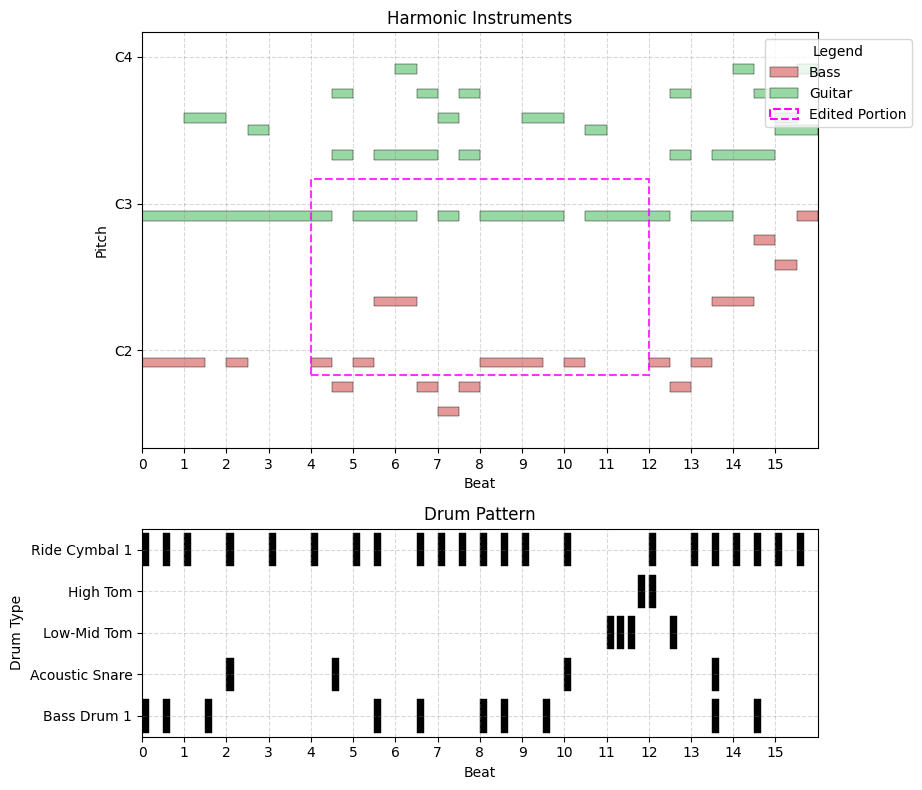

In [76]:
### Example 2: Box infill

def replace(
    e,
    ec,
    tick_range,
    pitch_range,
    drums,
    n_new_events,
):
    e = [ev for ev in e if not ev.is_inactive()]
    instruments = ec().a["instrument"]
    if not instruments:
        instruments = ec().a["instrument"]

    box_ticks = set(range(tick_range[0], tick_range[1]))
    valid_onsets = {str(r) for r in box_ticks}
    valid_offsets = {str(r) for r in range(tick_range[0] + 1, tick_range[1] + 1)}
    valid_pitches = {
        f"{r} (Drums)" if drums else f"{r}"
        for r in range(pitch_range[0], pitch_range[1])
    }
    def _min_tick(values):
        ints = [int(v) for v in values if v.isdigit()]
        return min(ints) if ints else None
    def _max_tick(values):
        ints = [int(v) for v in values if v.isdigit()]
        return max(ints) if ints else None
    def _pitch_in_box(pitch_set):
        return bool(pitch_set & valid_pitches)
    filtered = []
    for ev in e:
        start = _min_tick(ev.a["onset/global_tick"])
        end = _max_tick(ev.a["offset/global_tick"])
        pitch_in = _pitch_in_box(ev.a["pitch"])
        # only consider notes that overlap the pitch range
        if not pitch_in:
            filtered.append(ev)
            continue
        # check time overlap with box
        starts_before = start is not None and start < tick_range[0]
        starts_in = start is not None and tick_range[0] <= start < tick_range[1]
        ends_in = end is not None and tick_range[0] < end <= tick_range[1]
        ends_after = end is not None and end > tick_range[1]
        # note entirely in box -> delete
        if starts_in and ends_in:
            continue
        # note spans the entire box (starts before, ends after) -> delete
        if starts_before and ends_after:
            continue
        # note starts before and ends in box -> resample offset
        if starts_before and ends_in:
            ev.a["offset/global_tick"] = valid_offsets.copy()
            filtered.append(ev)
            continue
        # note starts in box and ends outside -> resample onset
        if starts_in and ends_after:
            ev.a["onset/global_tick"] = valid_onsets.copy()
            filtered.append(ev)
            continue
        # note doesn't touch the box at all
        filtered.append(ev)
    infill_constraint = {
        "pitch": valid_pitches | {"-"},
        "onset/global_tick": valid_onsets | {"-"},
        "offset/global_tick": valid_offsets | {"-"},
        "instrument": ({"Drums"} if drums else instruments - {"Drums"}) | {"-"},
    }
    # force at least one event
    filtered += [ec().intersect(infill_constraint).force_active() for _ in range(n_new_events)]
    # pad with inactive notes
    filtered += [ec().force_inactive() for _ in range(N_EVENTS - len(filtered))]
    return filtered

# load midi
sm = symusic.Score("rock_loop_2.mid")

e = sm_to_constraint(sm)

print("Generating Box Inpainting Example...")
# Use the previously generated sm as source
source_constraints = sm_to_constraint(sm)
tick_range = (96, 288)
pitch_range = (34, 50)
inpaint_constraints = replace(source_constraints, ec, tick_range=tick_range, pitch_range=pitch_range, drums= False, n_new_events= 18)
sm_inpainted = generate_from_constraints(inpaint_constraints, {"temperature": 1.0, "constraint_cfg": 1.0, "tokens_per_step": 1})
print(f"Generated {sm_inpainted.note_num()} notes")
preview_sm(sm_inpainted, soundfont_path=SF_PATH)



fig = plot_piano_roll(sm_inpainted, highlight={"tick_range": tick_range   , "pitch_range": pitch_range})

fig.savefig("infill.pdf")
# save sm as infill
sm_inpainted.dump_midi("infill.mid")

is 

Generating...


100%|██████████| 440/440 [00:06<00:00, 64.03it/s]


Number of notes before: 86
Number of notes after: 71


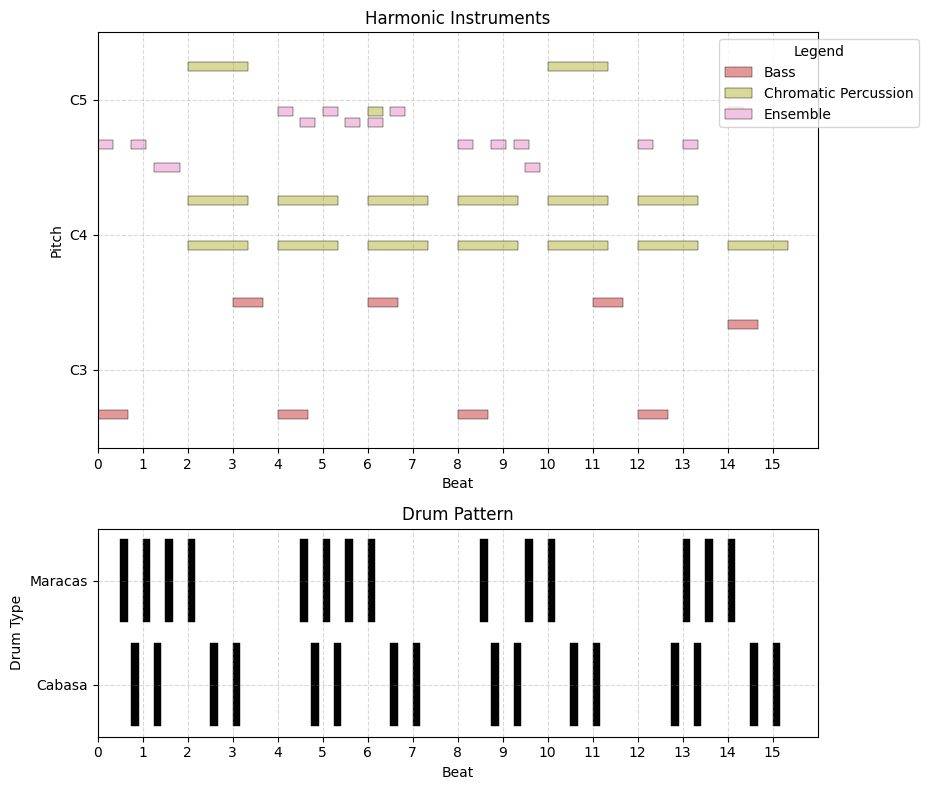

In [78]:
### Example 3: Generation from unusual constraint
def constraint_unusual(e, ec):
    # add some chromatic percussion
    e = []
    e += [ec().intersect({"instrument": {"Chromatic Percussion"}, "duration":{"1/4"}, "onset/global_tick": {str(tick) for tick in range(16, 384, 16)}})
    .intersect(ec().pitch_in_scale_constraint("A# kaweco",(24, 108))).force_active() for i in range(32)]
    # add ten percussion
    e += [ec().intersect({"instrument": {"Drums"}, "pitch": PERCUSSION_PITCHES}).force_active() for i in range(10)]
    # add 30 percussion pitches with velocity less than 50
    e += [ec().intersect({"instrument": {"Drums"}, "pitch": PERCUSSION_PITCHES}).intersect(ec().velocity_constraint(50)).force_active() for i in range(10)]
    # add 30 percussion pitches with velocity greater than 100
    e += [ec().intersect({"instrument": {"Drums"}, "pitch": PERCUSSION_PITCHES}).intersect(ec().velocity_constraint(100)).force_active() for i in range(10)]
    # add some pipe flute
    e += [ec().intersect({"instrument": {"Ensemble"}, "duration": {"1/16"}}).force_active() for i in range(16)]
    # add some synth bass
    e += [ec().intersect({"instrument": {"Bass"}, "duration": {"1/8"}}).force_active() for i in range(8)]
    # set tempo to 130
    e = [ev.intersect(ec().tempo_constraint(100)) for ev in e]
    # pad remaining space
    e += [ec().force_inactive() for _ in range(N_EVENTS - len(e))]
    return e

# render examples
e = constraint_unusual([], ec)
sm = generate_from_constraints(e, {"temperature": 1.0})
preview_sm(sm, soundfont_path=SF_PATH)
fig =plot_piano_roll(sm)

fig.savefig("unusual.pdf")